In [339]:
%reload_ext autoreload
%autoreload 2

import datetime as dt
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..\..')

from Crypto.lib.backtest_statistics import account_curve_statistics
from Crypto.lib.constants import COINBASE_CRYPTOS
from Crypto.lib.data import import_data

pd.options.mode.chained_assignment = None

In [340]:
close = import_data()
close = close.resample("15T", label='right').last().ffill()

In [321]:
def compute_signal(close, speed):
    ma_xover = (close.ewm(speed).mean() - close.ewm(3 * speed).mean())
    iosc = ma_xover / ma_xover.ewm(3 * speed).std()
    iosc = iosc.clip(-3., 3.)
    iosc = iosc.ffill(limit=5)
    return iosc

def compute_daily_pnl(signal, close, cost):
    close = close.reindex_like(signal)
    positions = (signal / close).ffill(limit=5)  # $-neutral
    notional = positions * close
    trades = positions.diff().fillna(0.0)
    costs = trades.abs() * close * cost
    
    pnl_raw = positions.shift() * close.diff()
    pnl_cost = pnl_raw - costs
    pnl_raw = pnl_raw.resample("D").sum().cumsum()
    pnl_cost = pnl_cost.resample("D").sum().cumsum()
    
    pnl_long_raw = positions.shift().where(positions.shift() > 0) * close.diff()
    pnl_short_raw = positions.shift().where(positions.shift() < 0) * close.diff()
    pnl_long_raw = pnl_long_raw.resample("D").sum().cumsum()
    pnl_short_raw = pnl_short_raw.resample("D").sum().cumsum()
    
    return {
        "pnl_raw": pnl_raw,
        "pnl_cost": pnl_cost,
        "notional": notional,
        "positions": positions,
        "costs": costs,
        "pnl_long_raw": pnl_long_raw,
        "pnl_short_raw": pnl_short_raw,
    }

def print_time(minutes):
    if minutes < 60:
        return f"{minutes}min"
    else: 
        return f"{minutes // 60}h{minutes % 60}min"

# Focusing on COINBASE Cryptos

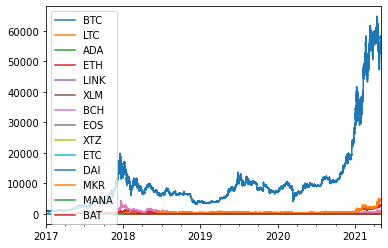

In [322]:
close.loc["2017":, COINBASE_CRYPTOS].plot();

# Mean reversion of momentum?

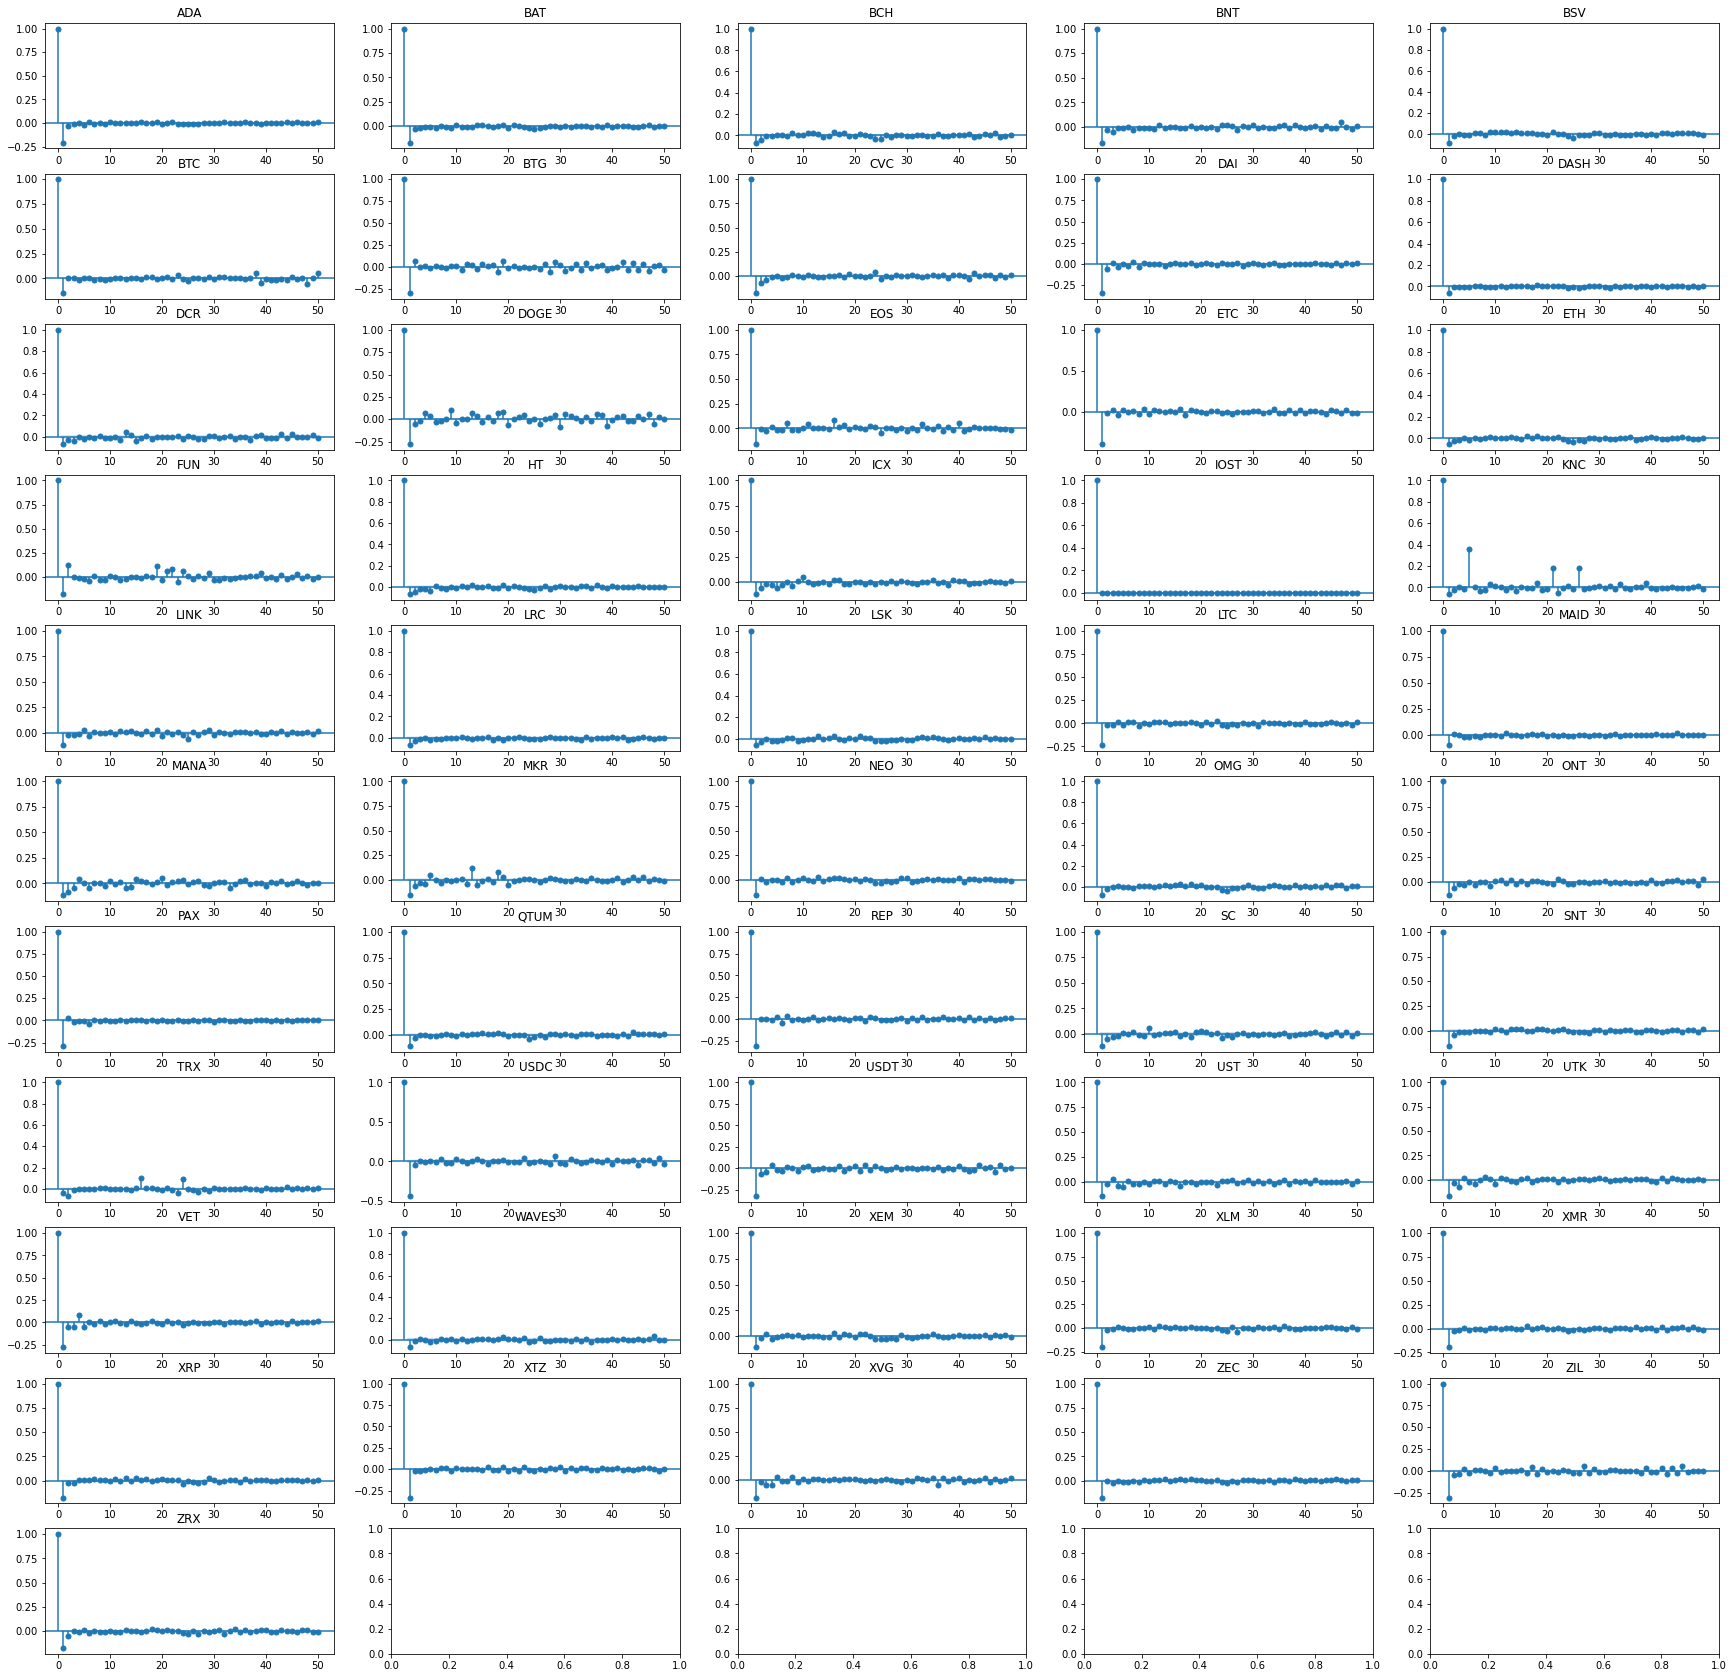

In [334]:
from statsmodels.graphics.tsaplots import plot_acf
hourly_returns = close.resample("1H", label='right').last().ffill().pct_change()

fig, axes = plt.subplots(11, 5, figsize=(30, 30))

for i, market in enumerate(hourly_returns.columns):
    plot_acf(hourly_returns[market].dropna(), lags=50, ax=axes[i // 5, i % 5]);
    axes[i // 5, i % 5].set_title(market);

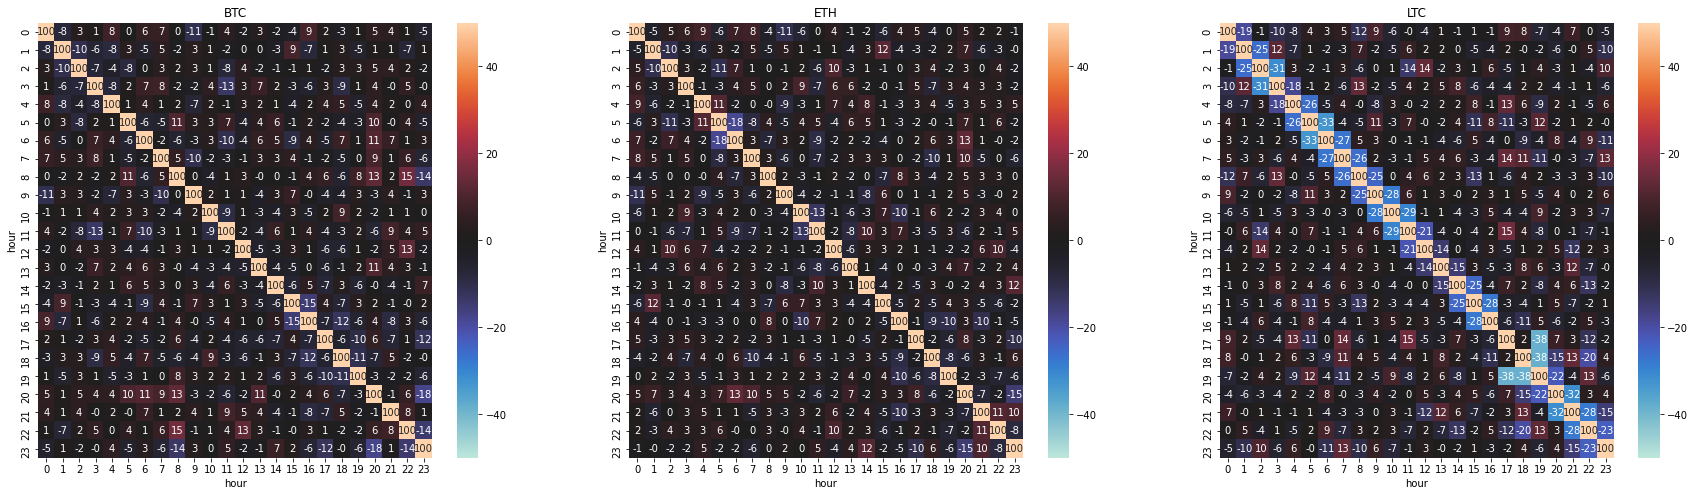

In [124]:
def plot_intraday_corr(close, market, freq, axes):
    df = close[[market]].resample(freq, label='right').last().ffill().pct_change()
    df["hour"] = df.index.hour
    df["date"] = df.index.date
    df = df.groupby(["date", "hour"])[market].mean().unstack().fillna(0.)

    corr = df.corr() * 100
    # corr[corr.abs() < 0.05] = np.nan
    sns.heatmap(corr, center=0., vmin=-50, vmax=50, annot=True, ax=axes, fmt=".0f");
    axes.set_title(market)

freq = "1H"
fig, axes = plt.subplots(1, 3, figsize=(30, 8))
plot_intraday_corr(close, "BTC", freq, axes[0])
plot_intraday_corr(close, "ETH", freq, axes[1])
plot_intraday_corr(close, "LTC", freq, axes[2])

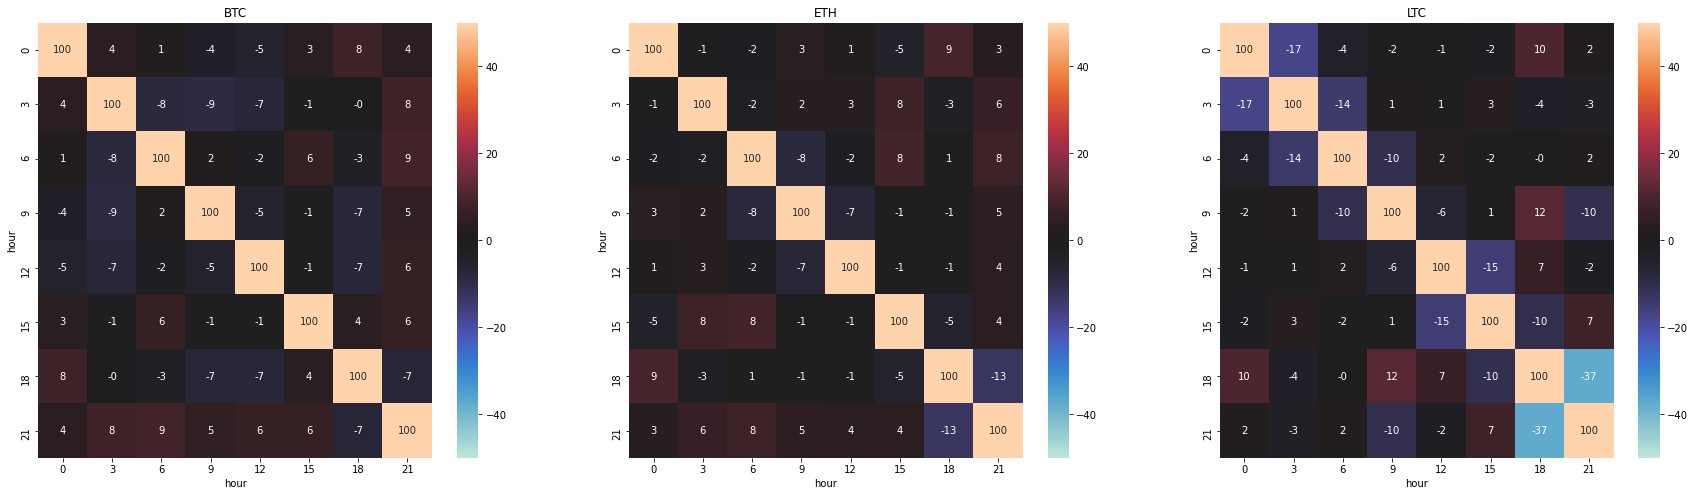

In [198]:
freq = "3H"
fig, axes = plt.subplots(1, 3, figsize=(30, 8))
plot_intraday_corr(close, "BTC", freq, axes[0])
plot_intraday_corr(close, "ETH", freq, axes[1])
plot_intraday_corr(close, "LTC", freq, axes[2])

# Weights analysis

In [270]:
weights = compute_signal(close, 128)
weights = weights.loc["2017":, COINBASE_CRYPTOS]

In [271]:
weights.describe().T

count      mean       std  min       25%       50%       75%  max
BTC   455905.0  0.331554  1.610705 -3.0 -0.895504  0.396640  1.559094  3.0
LTC   455899.0  0.091746  1.540986 -3.0 -1.028353  0.021549  1.256330  3.0
ADA   333780.0  0.007281  1.593791 -3.0 -1.172930 -0.032930  1.159978  3.0
ETH   455905.0  0.264480  1.590188 -3.0 -0.895246  0.255993  1.400238  3.0
LINK  193535.0  0.177074  1.578617 -3.0 -0.976867  0.180415  1.316830  3.0
XLM   324863.0 -0.080875  1.564136 -3.0 -1.227046 -0.111192  1.014082  3.0
BCH   357407.0 -0.016303  1.544682 -3.0 -1.129556 -0.093725  1.093476  3.0
EOS   403775.0  0.025779  1.537102 -3.0 -1.063722 -0.025597  1.121574  3.0
XTZ   403063.0  0.009073  1.540776 -3.0 -1.110121 -0.058449  1.090510  3.0
ETC   455902.0  0.047681  1.545619 -3.0 -1.072865 -0.021900  1.156974  3.0
DAI   322944.0 -0.126128  1.360149 -3.0 -1.104081 -0.167514  0.836917  3.0
MKR   307191.0  0.107960  1.515743 -3.0 -1.004866  0.086580  1.233800  3.0
MANA  394776.0  0.060399  1.493049 -3.0 -1.011203  0.003460  1.113094  3.0
BAT   348506.0  0.061437  1.554091 -3.0 -1.079353  0.054269  1.179121  3.0

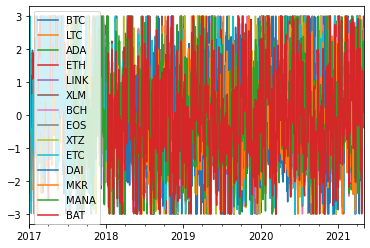

In [272]:
weights.resample("B").last().plot();

# Simulations

In [324]:
def plot_simulation(markets, cost, compute_signal):
    for speed in [2, 4, 8, 16, 32, 64, 128, 256]:
        weights = compute_signal(close, speed)
        weights = weights.loc["2017":"2019", markets]
        res = compute_daily_pnl(weights, close, cost)

        fig, axes = plt.subplots(1, 3, figsize=(30, 6))
        fig.suptitle(f"Speed: fast {print_time(speed * 15)}, slow {print_time(speed * 15 * 3)}")

        sr_all_raw = account_curve_statistics(res["pnl_raw"].sum(axis=1)).Sharpe
        sr_all_cost = account_curve_statistics(res["pnl_cost"].sum(axis=1)).Sharpe

        sr_raw = account_curve_statistics(res["pnl_raw"]).Sharpe
        sr_cost = account_curve_statistics(res["pnl_cost"]).Sharpe

        res["pnl_raw"].sum(axis=1).plot(ax=axes[0], label="Raw", title=f"All (SR: raw={sr_all_raw:.2f}, cost={sr_all_cost:.2f})");
        res["pnl_cost"].sum(axis=1).plot(ax=axes[0], label="Cost");
        axes[0].legend();

        sr_long_raw = account_curve_statistics(res["pnl_long_raw"].sum(axis=1)).Sharpe
        sr_short_raw = account_curve_statistics(res["pnl_short_raw"].sum(axis=1)).Sharpe

        res["pnl_long_raw"].sum(axis=1).plot(ax=axes[1], label="Longs", title=f"Long/Short Raw (SR: longs={sr_long_raw:.2f}, shorts={sr_short_raw:.2f})");
        res["pnl_short_raw"].sum(axis=1).plot(ax=axes[1], label="Shorts");
        axes[1].legend();

        res["pnl_raw"].columns = [f"{x} (SR:{sr_raw.loc[x]:.1f})" for x in res["pnl_raw"].columns]
        res["pnl_raw"].plot(ax=axes[2], title="Per coin");

## BTC & ETH

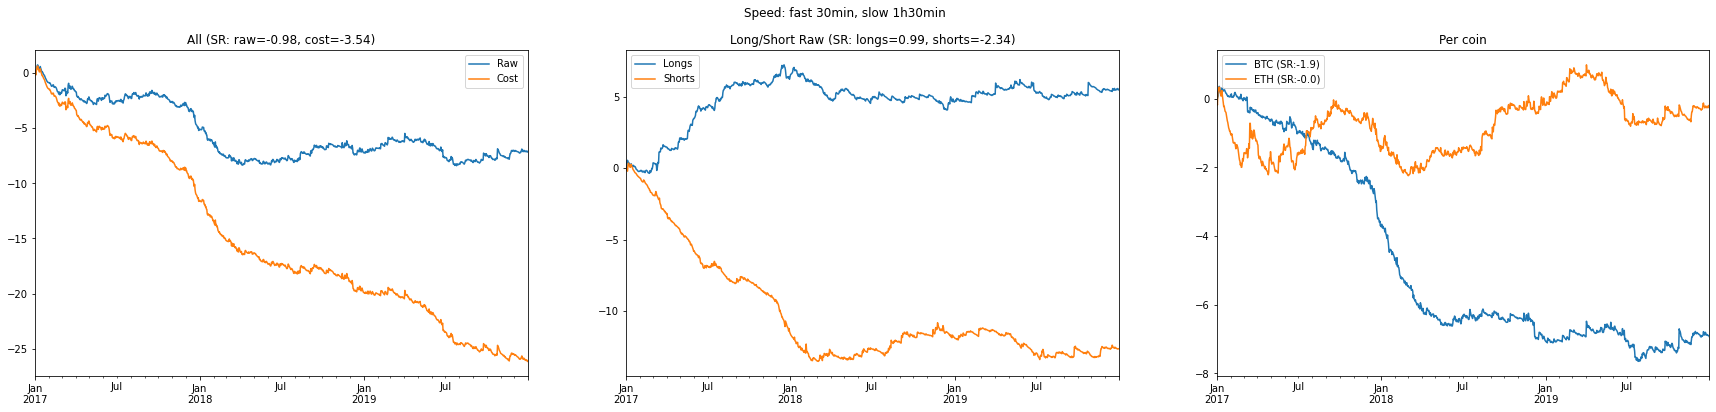

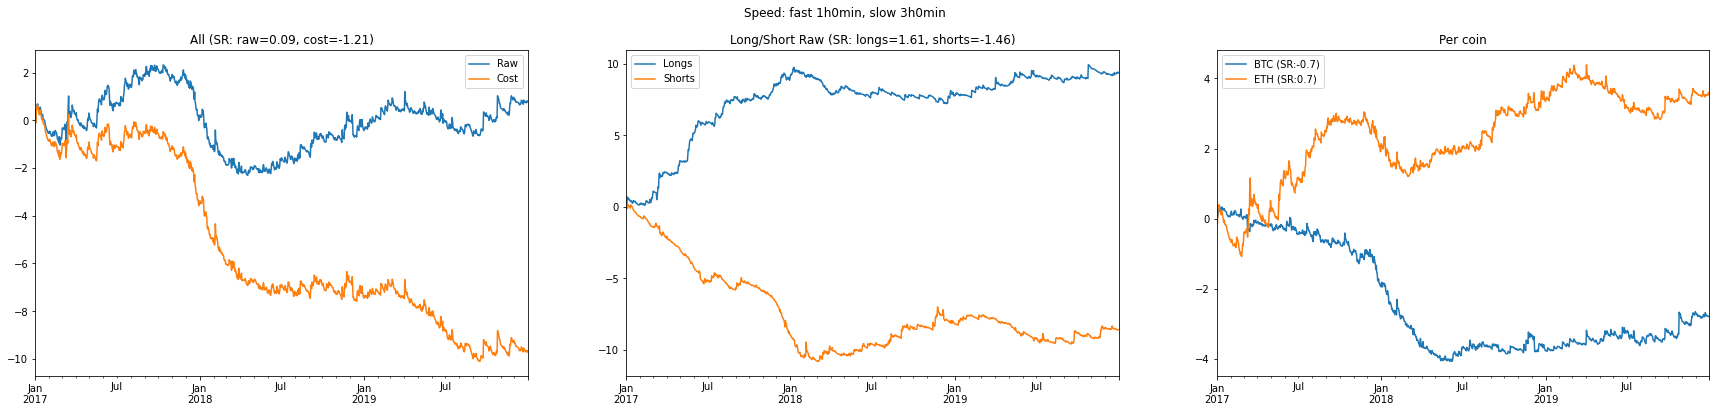

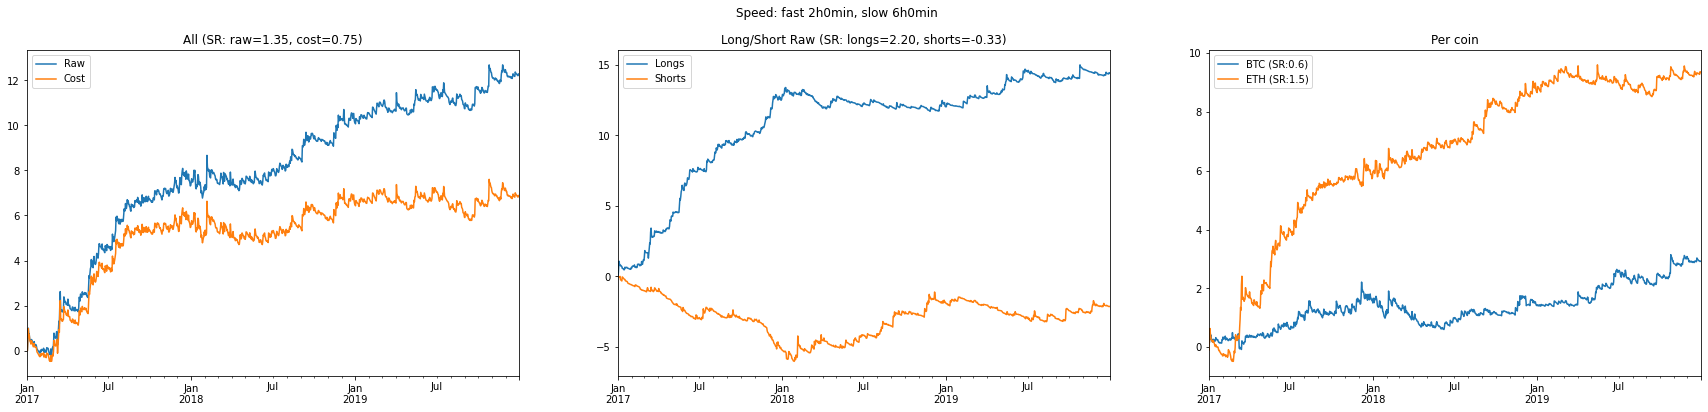

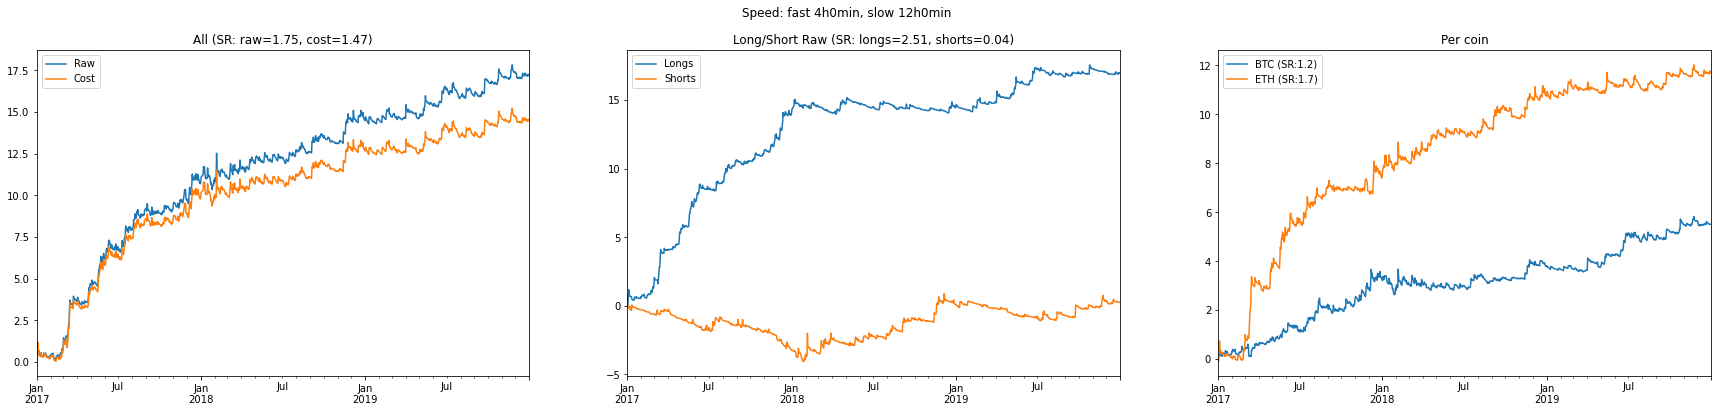

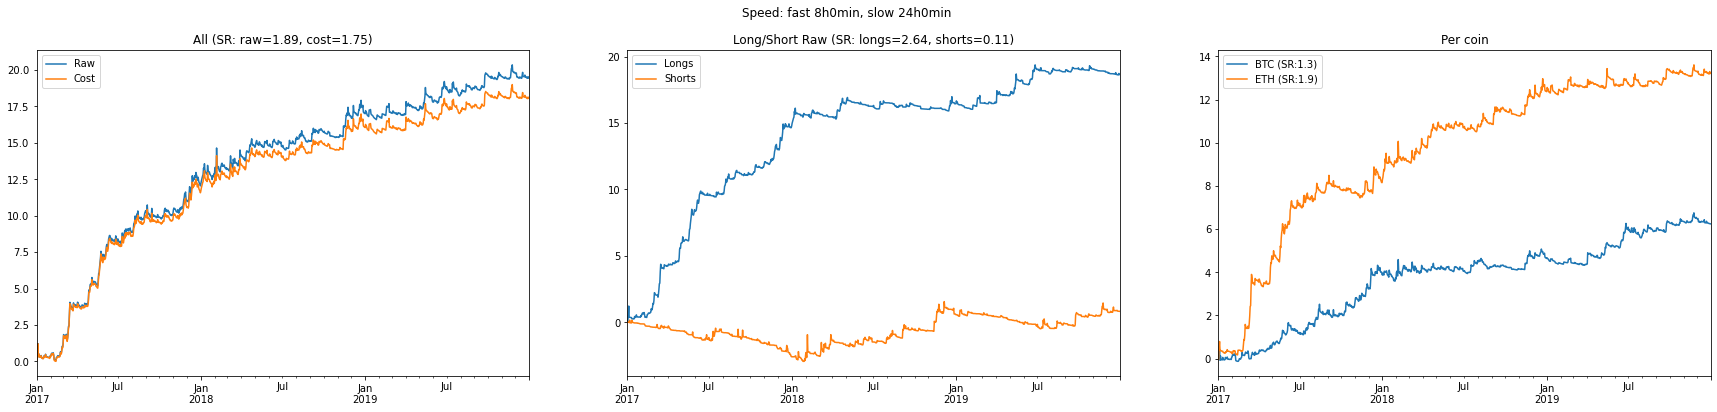

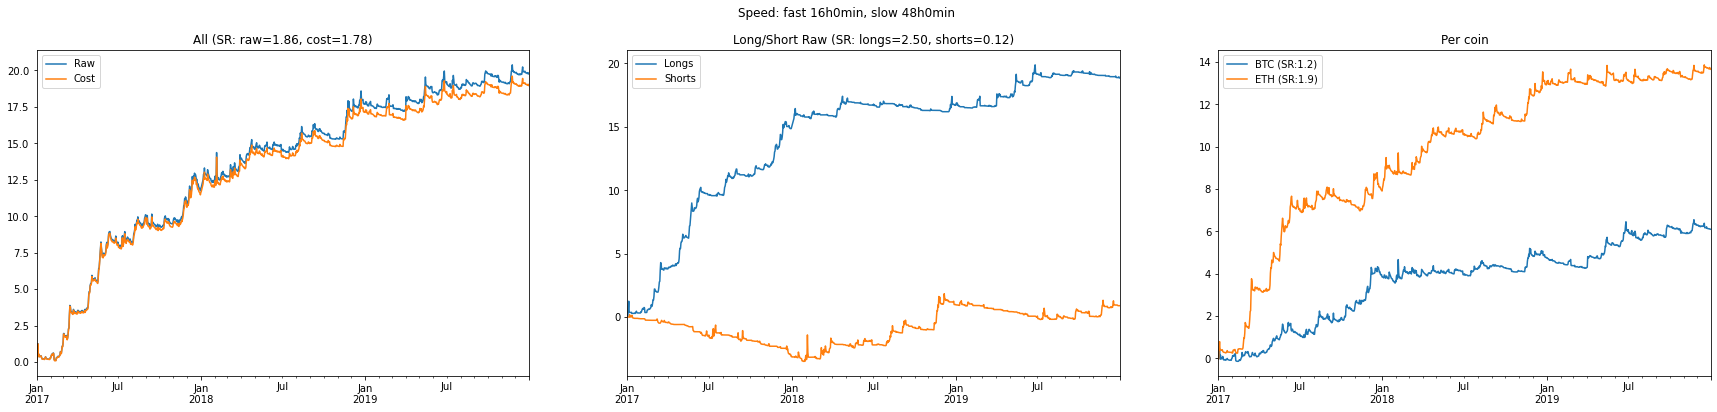

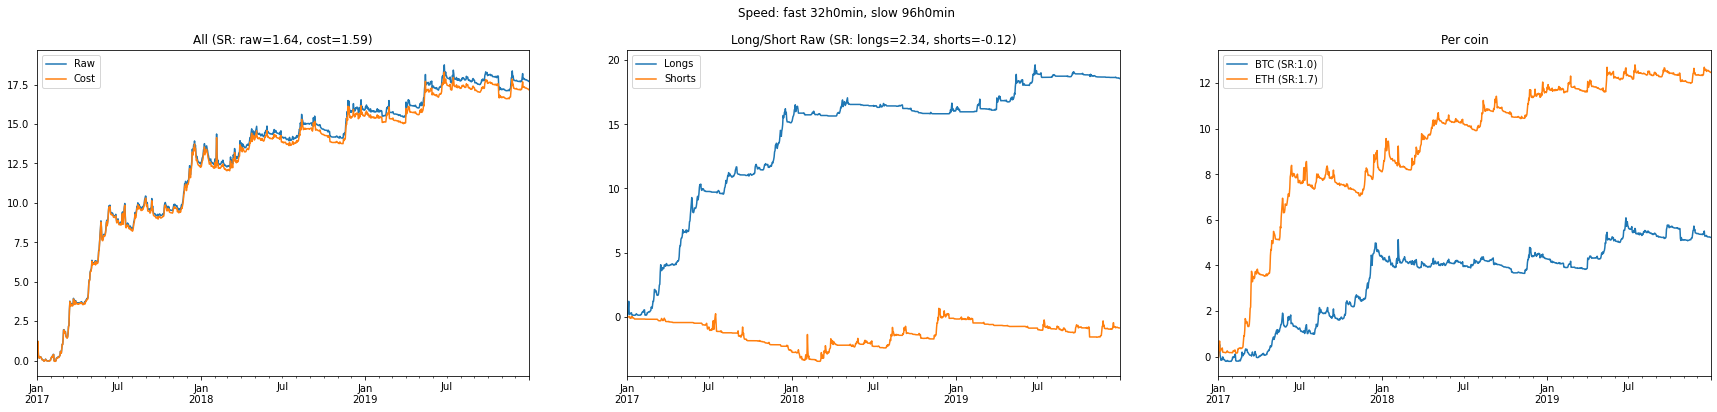

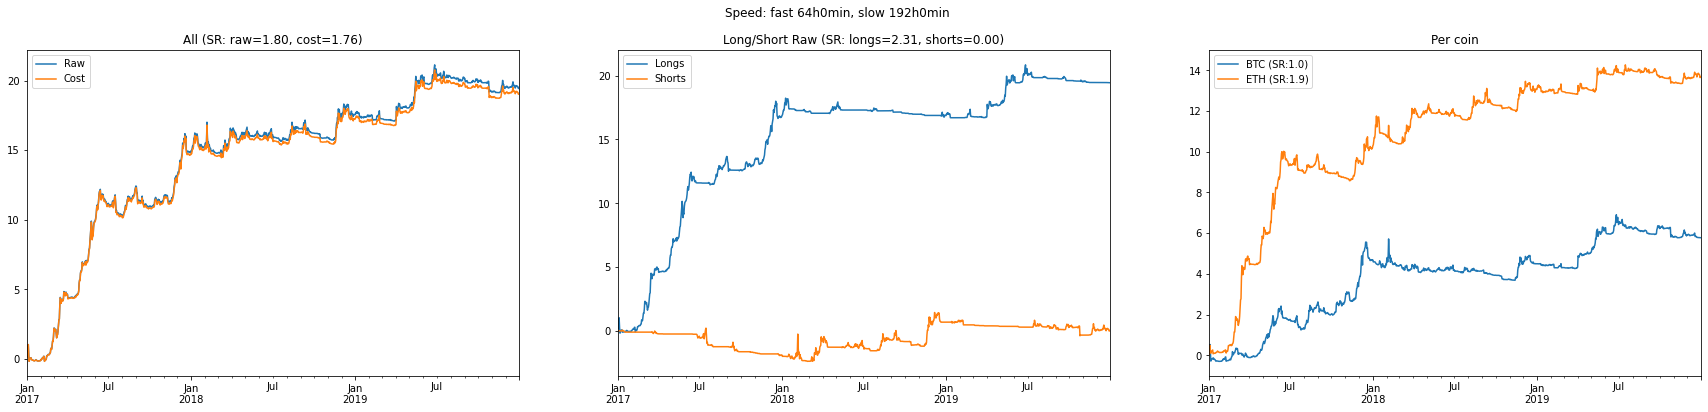

In [326]:
markets = ["BTC", "ETH"]
cost = 0.0003
plot_simulation(markets, cost, compute_signal)

## BTC & ETH & LTC

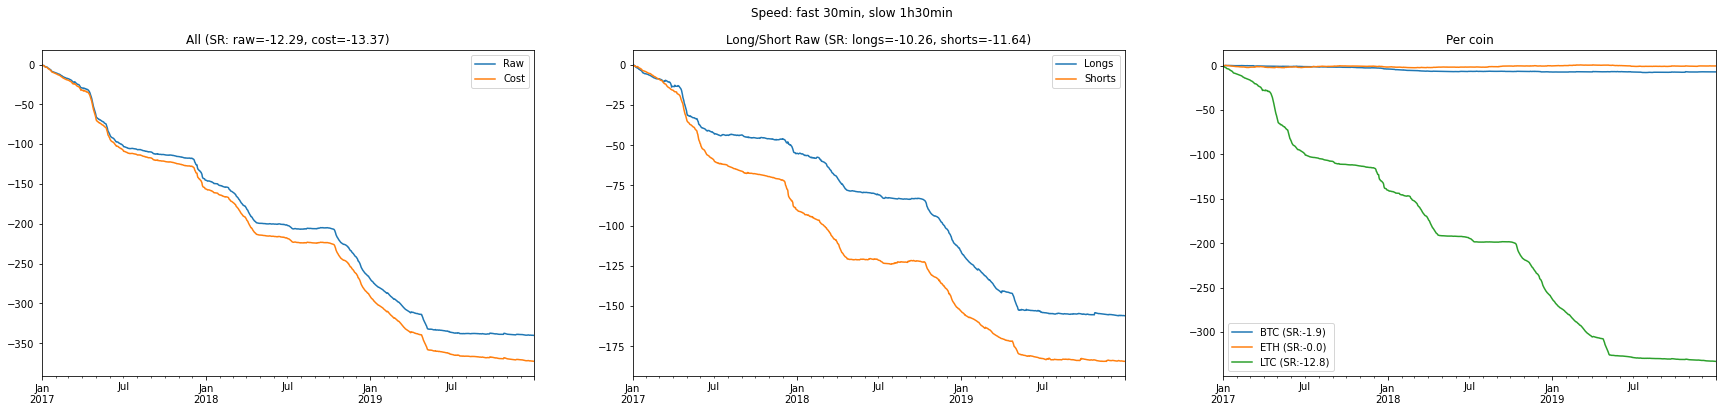

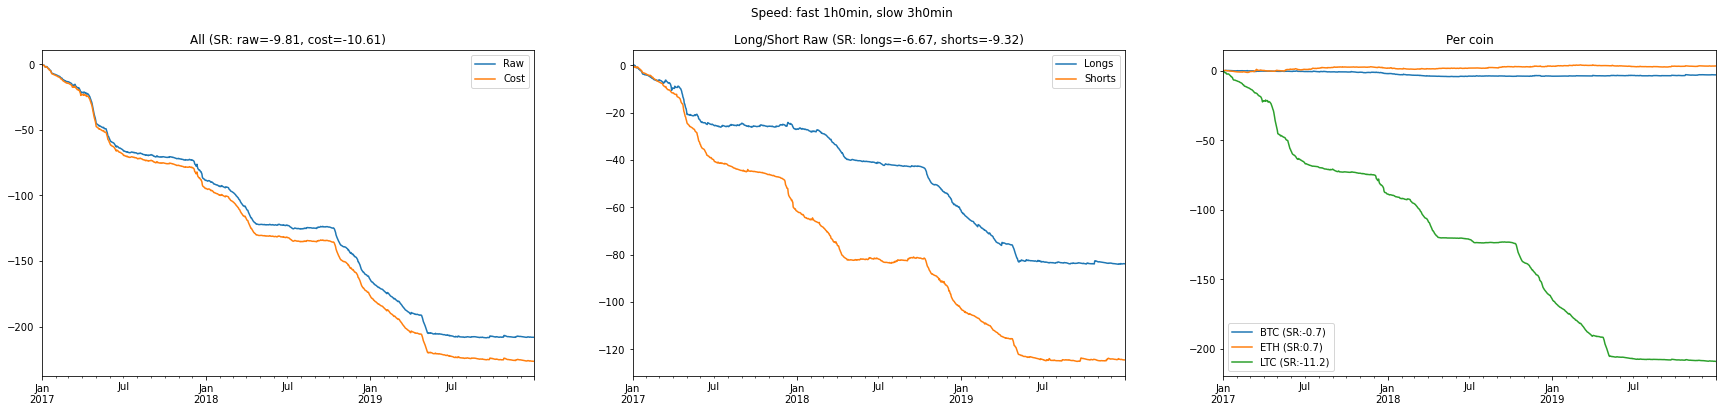

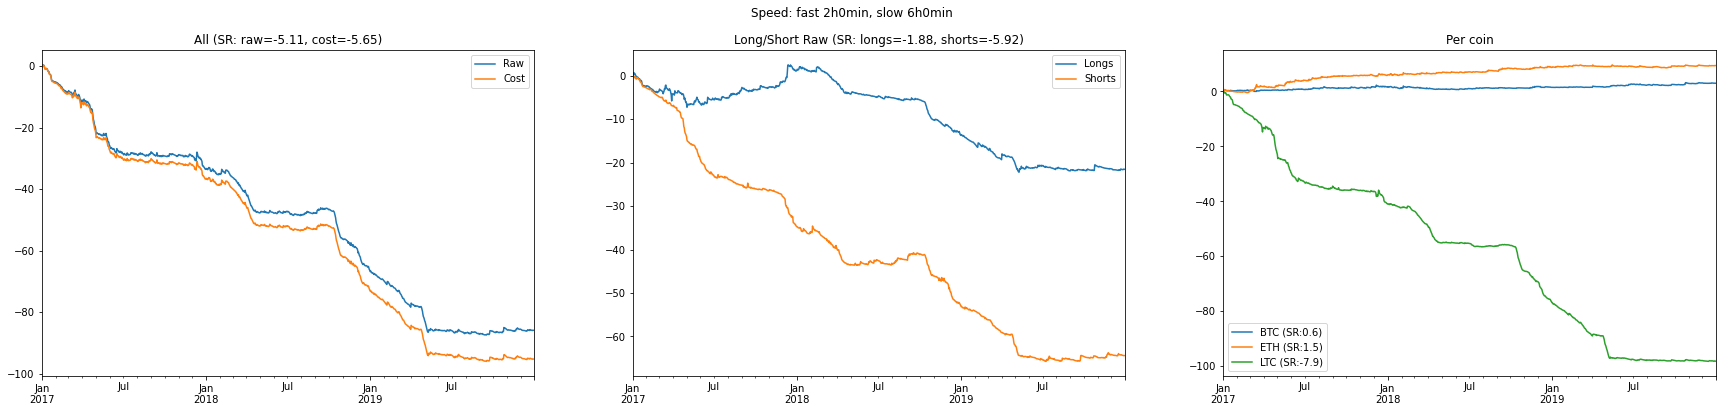

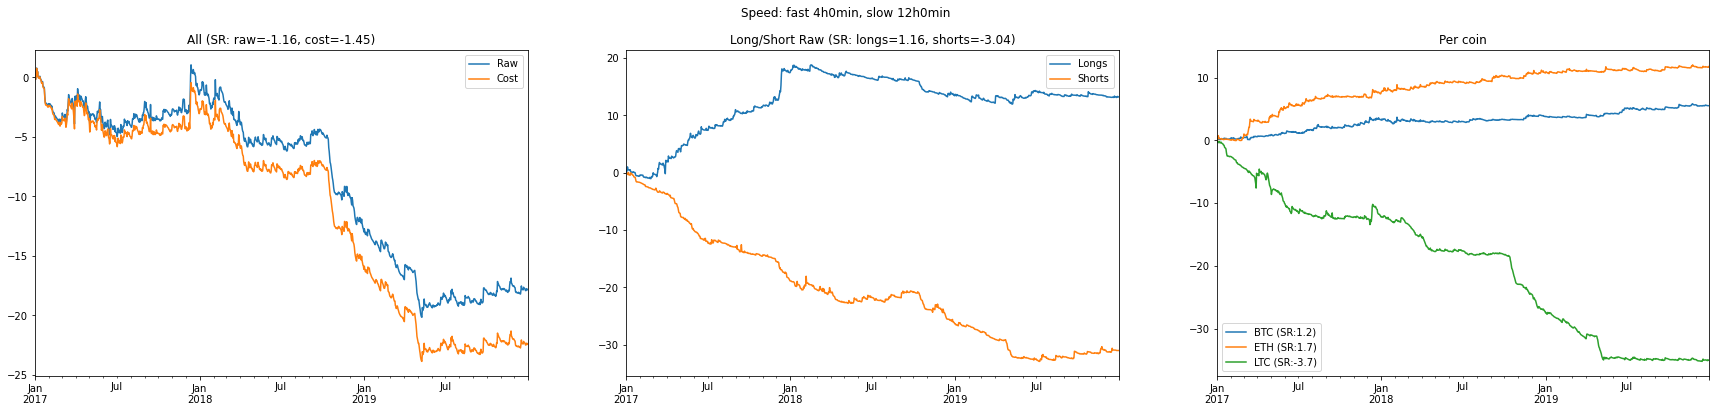

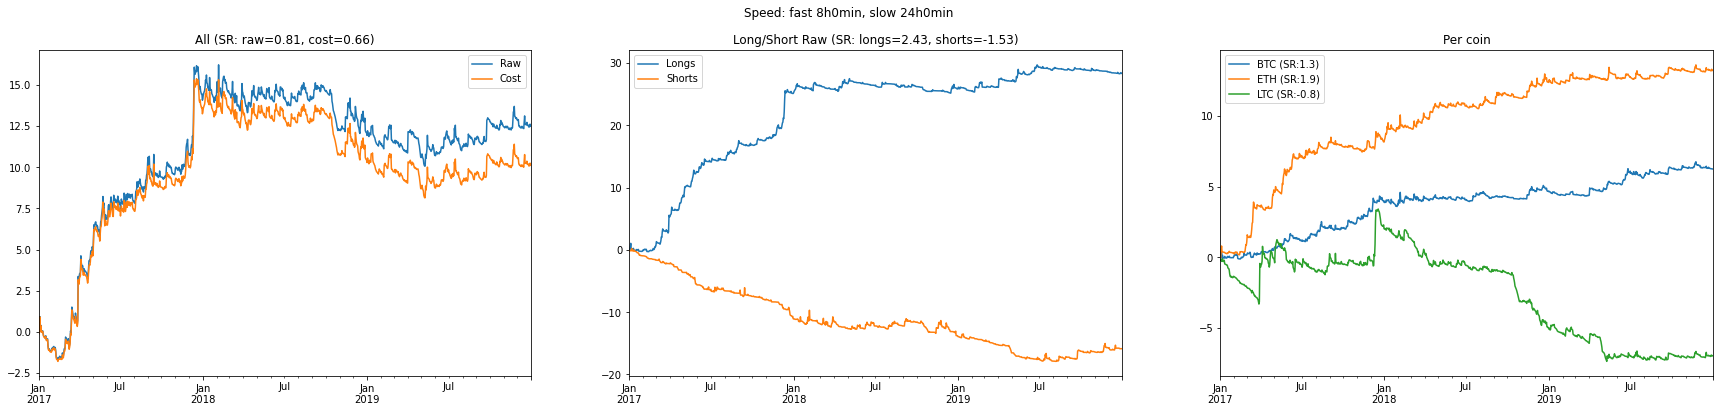

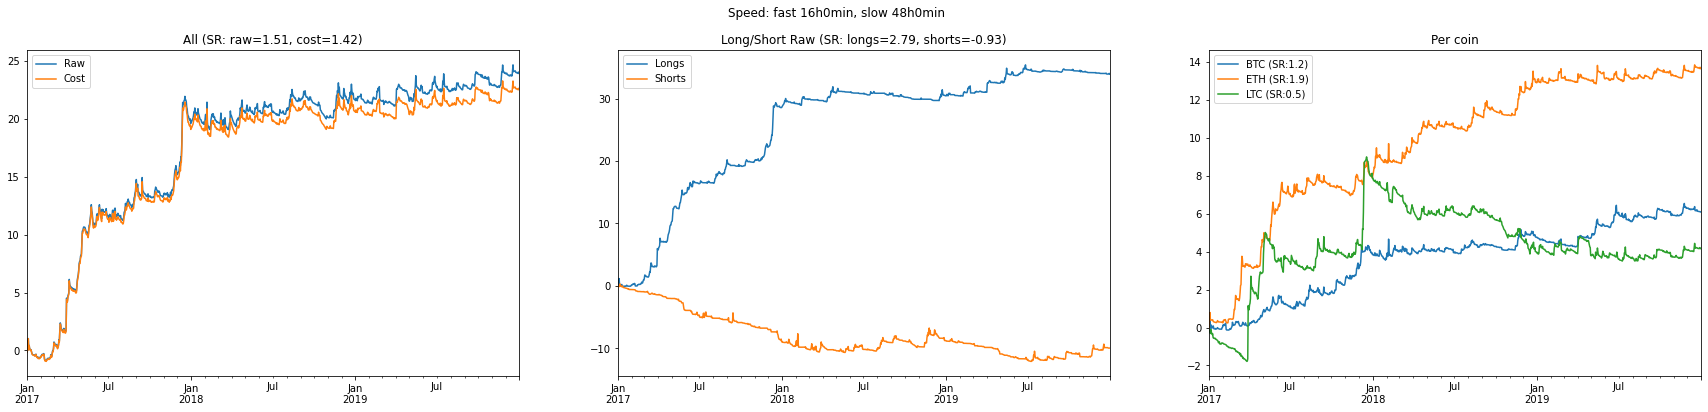

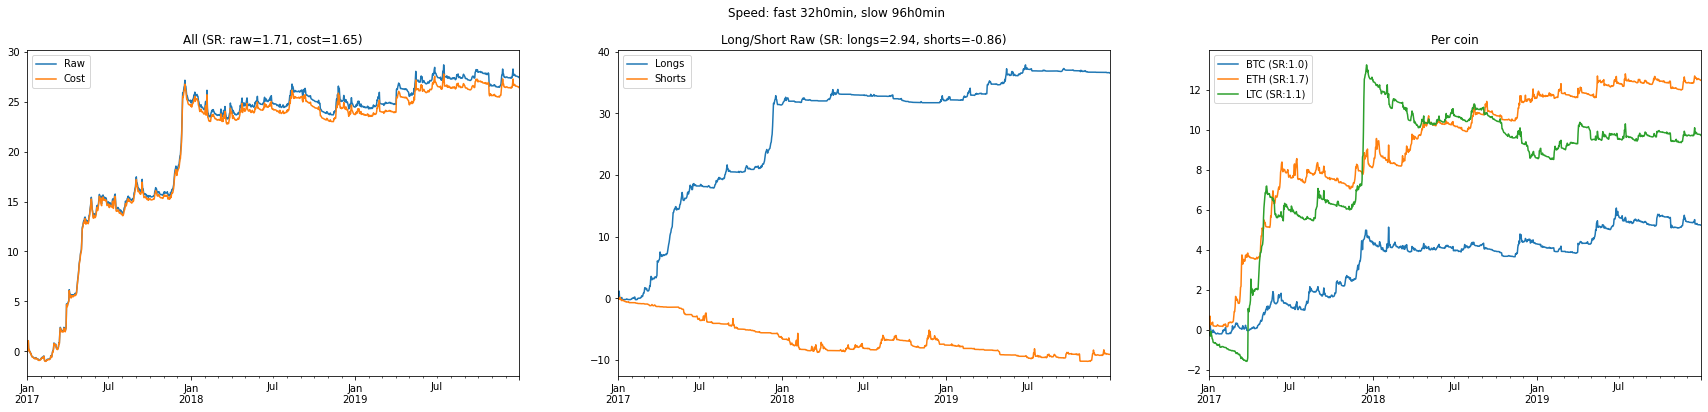

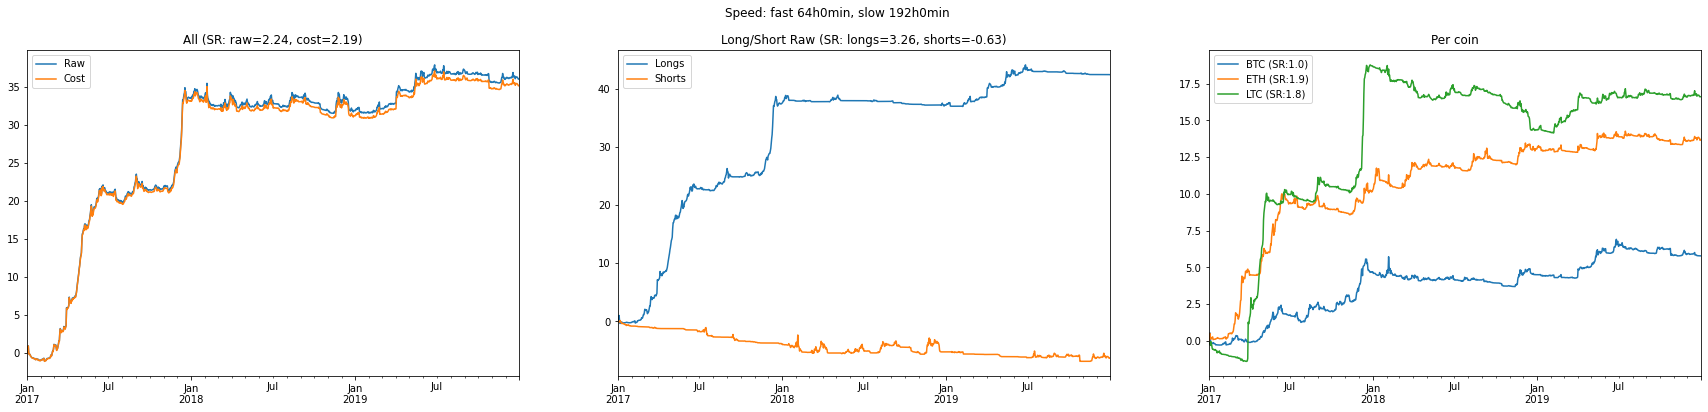

In [327]:
markets = ["BTC", "ETH", "LTC"]
cost = 0.0003
plot_simulation(markets, cost, compute_signal)

### All coinbase cryptos

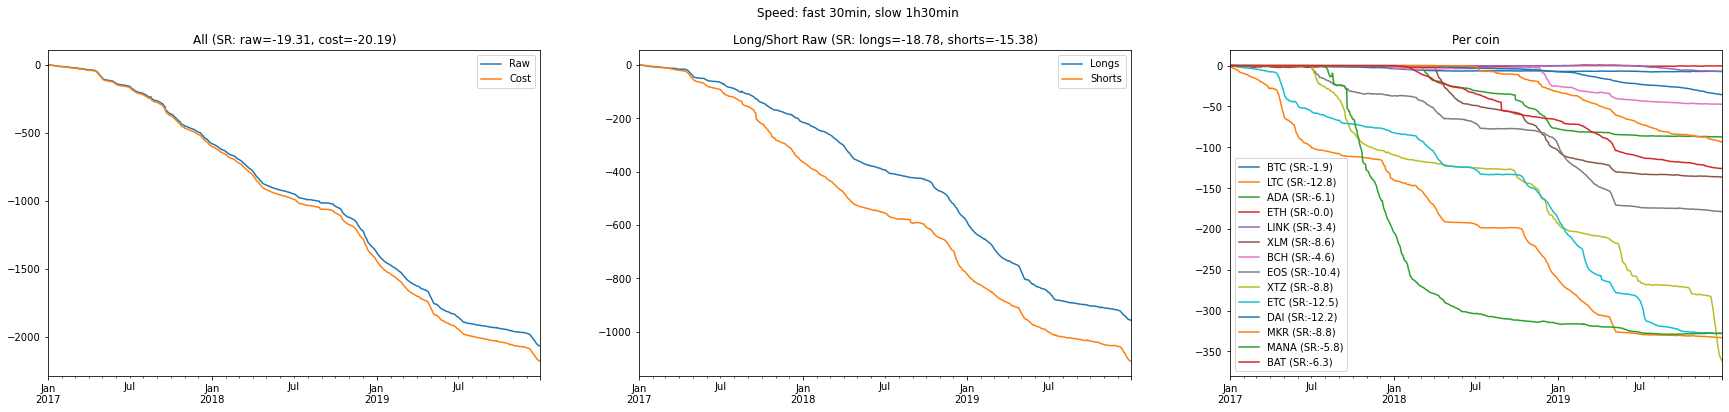

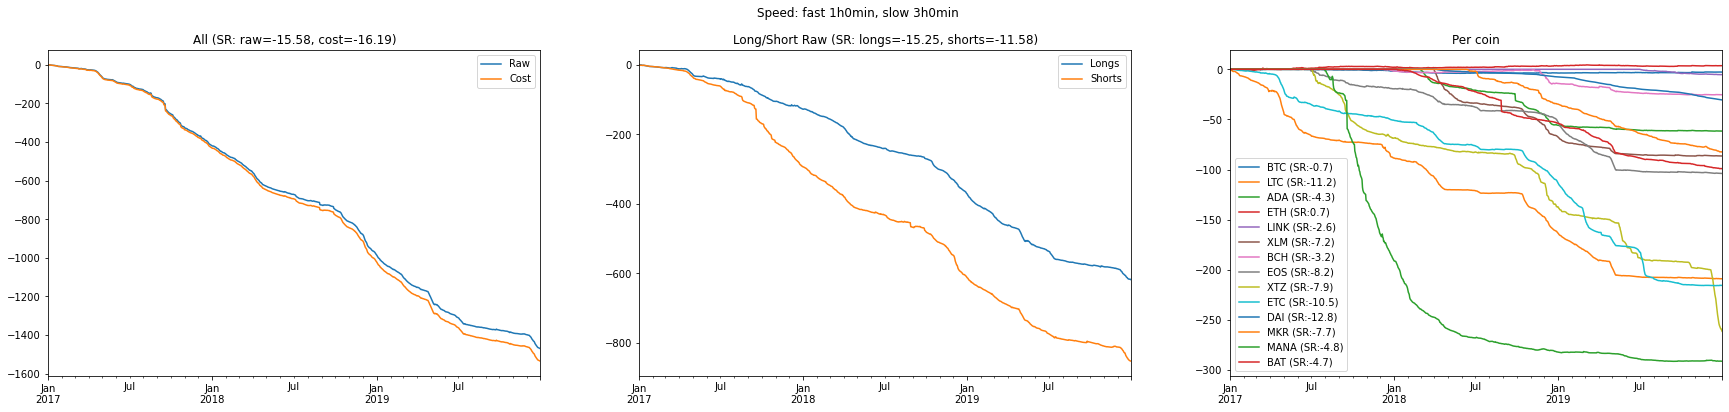

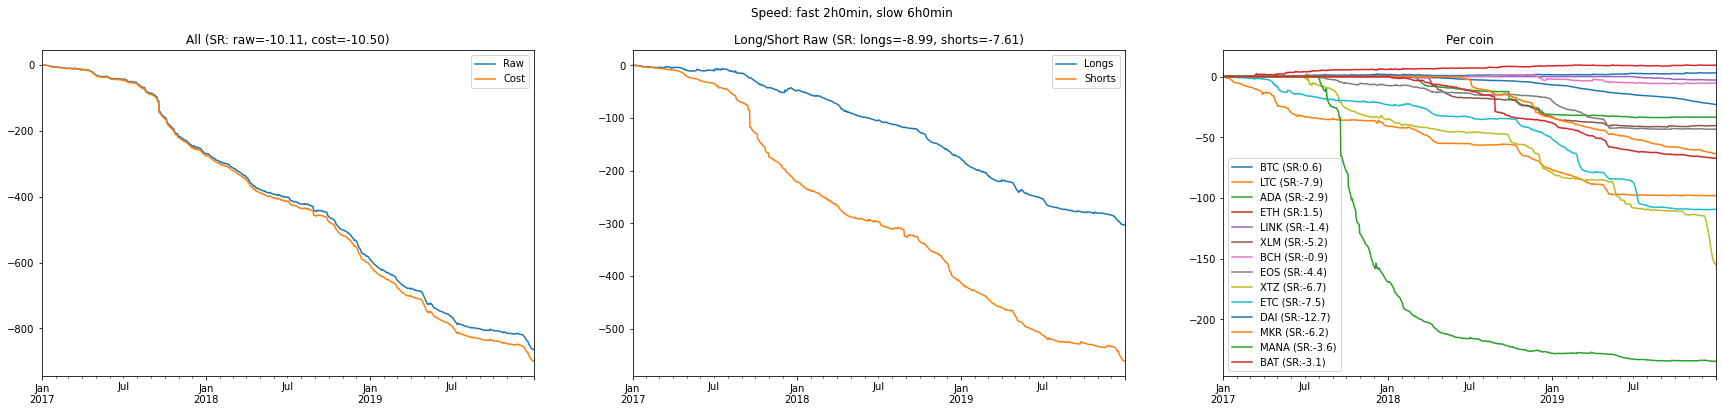

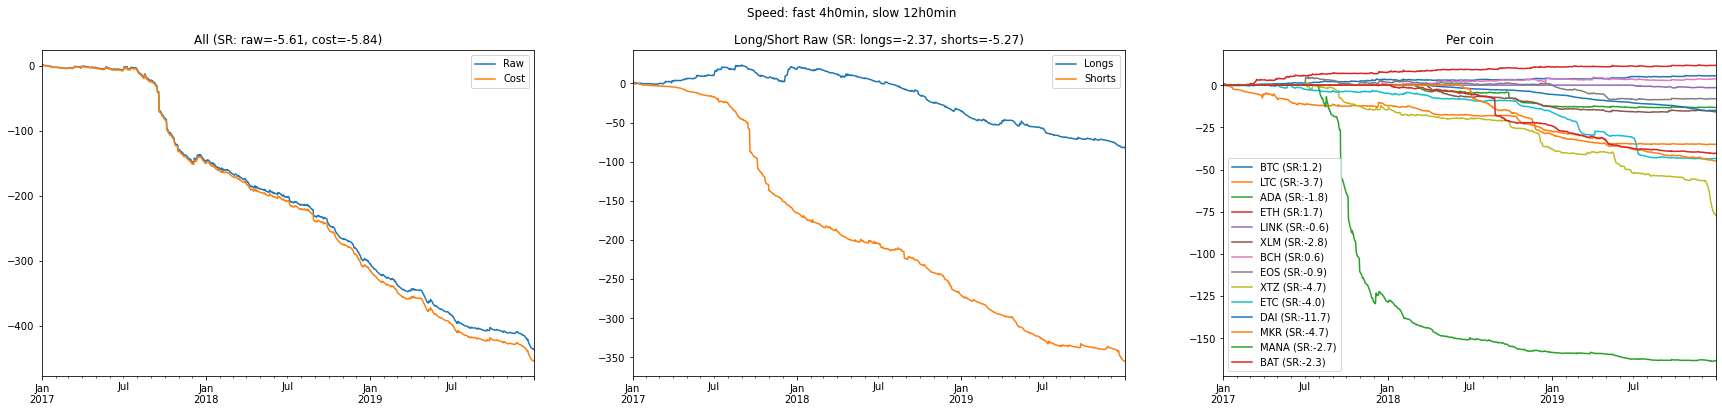

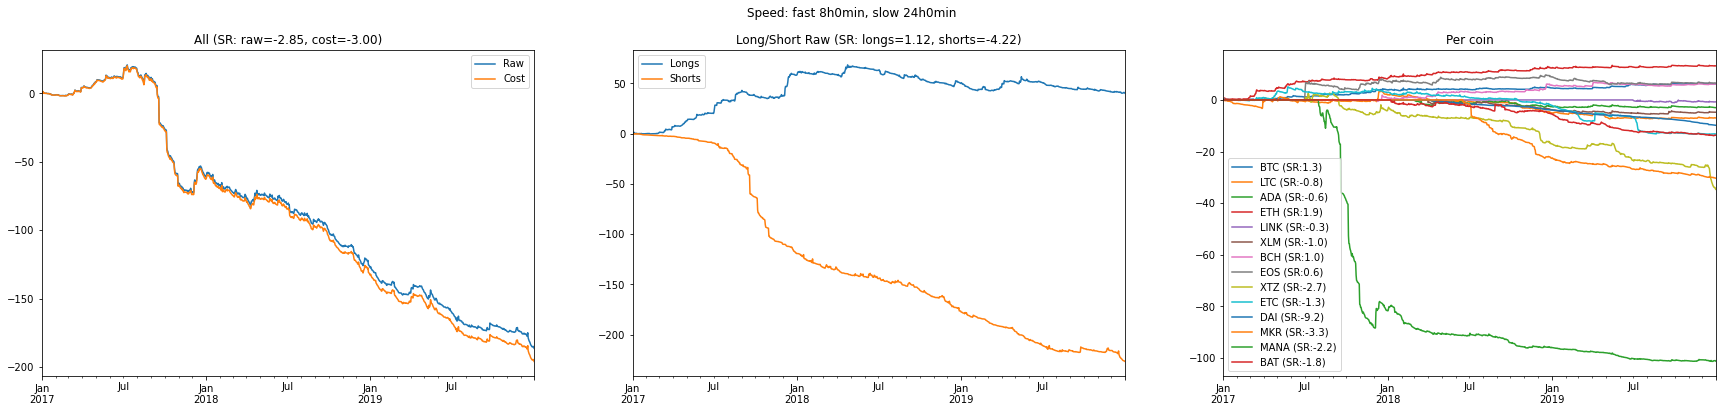

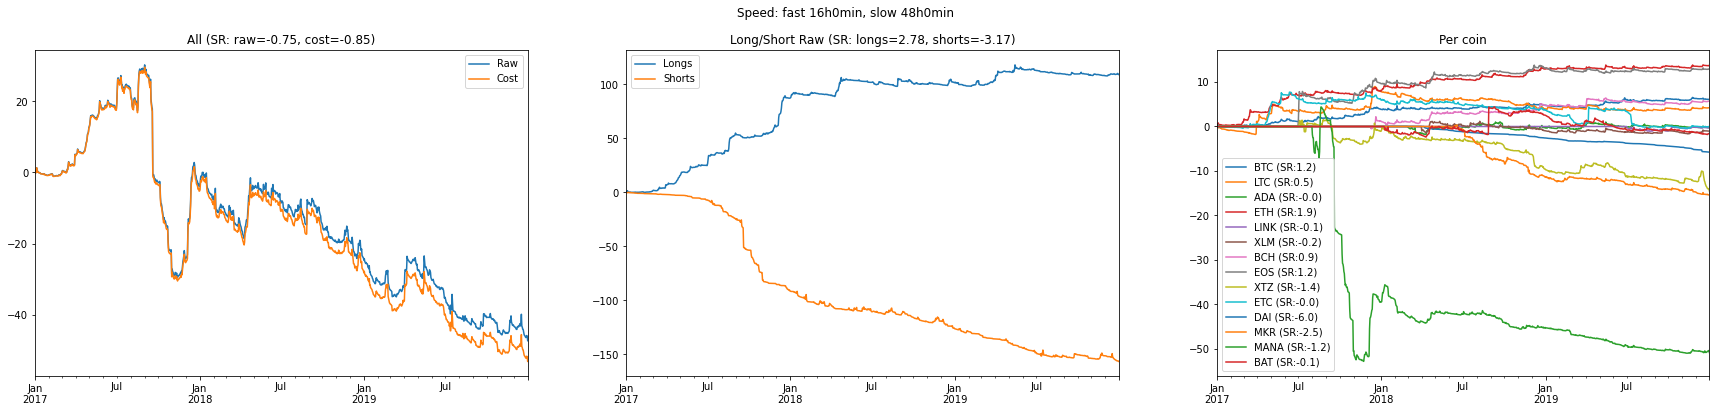

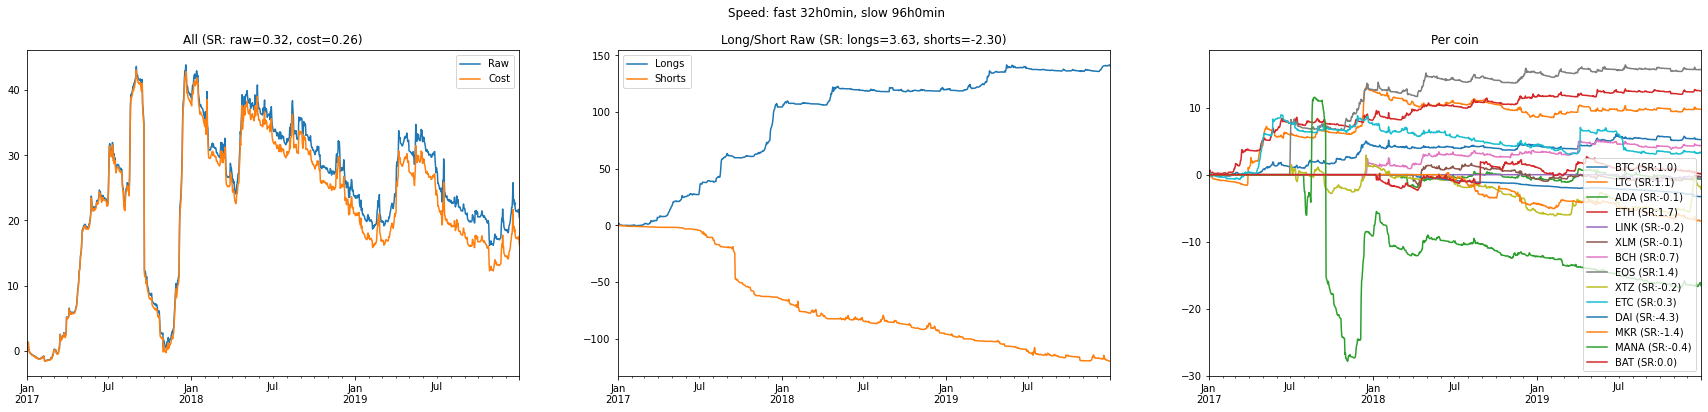

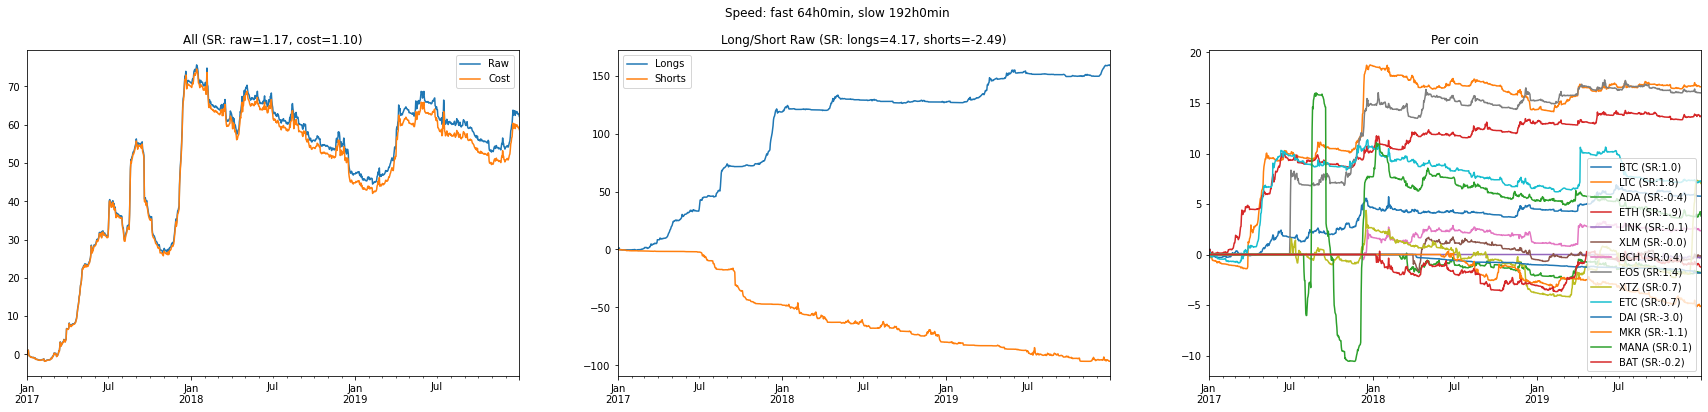

In [328]:
markets = COINBASE_CRYPTOS
cost = 0.0003
plot_simulation(markets, cost, compute_signal)

## Not trade on weak signal

In [337]:
def func(x):
    if x < -2.5:
        return -1.
    elif x < -0.5:
        return x + 0.5
    elif x < 0.5:
        return 0.
    elif x < 2.5:
        return x - 0.5
    else:
        return 1.

def compute_signal(close, speed):
    ma_xover = (close.ewm(speed).mean() - close.ewm(3 * speed).mean())
    iosc = ma_xover / ma_xover.ewm(3 * speed).std()
    iosc = iosc.applymap(func)
    iosc = iosc.ffill(limit=5)
    return iosc

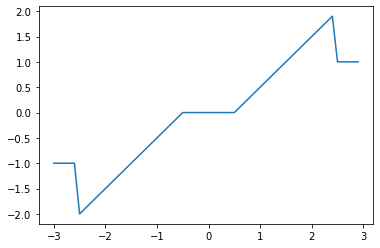

In [330]:
xs = np.arange(-3., 3., 0.1)
vals = [func(x) for x in xs]
plt.plot(xs, vals);

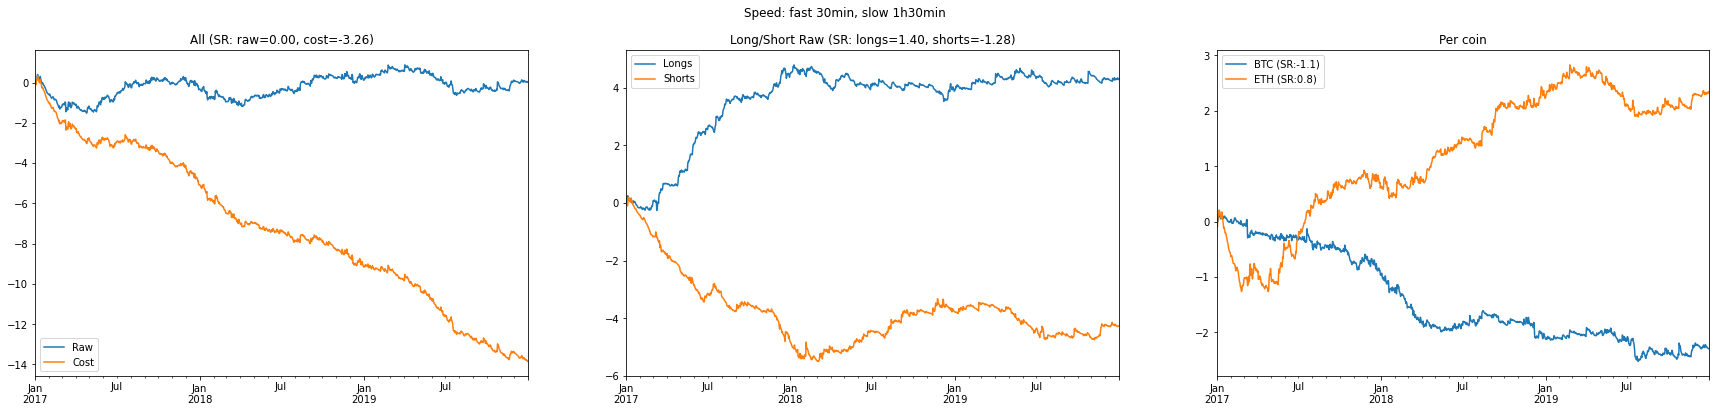

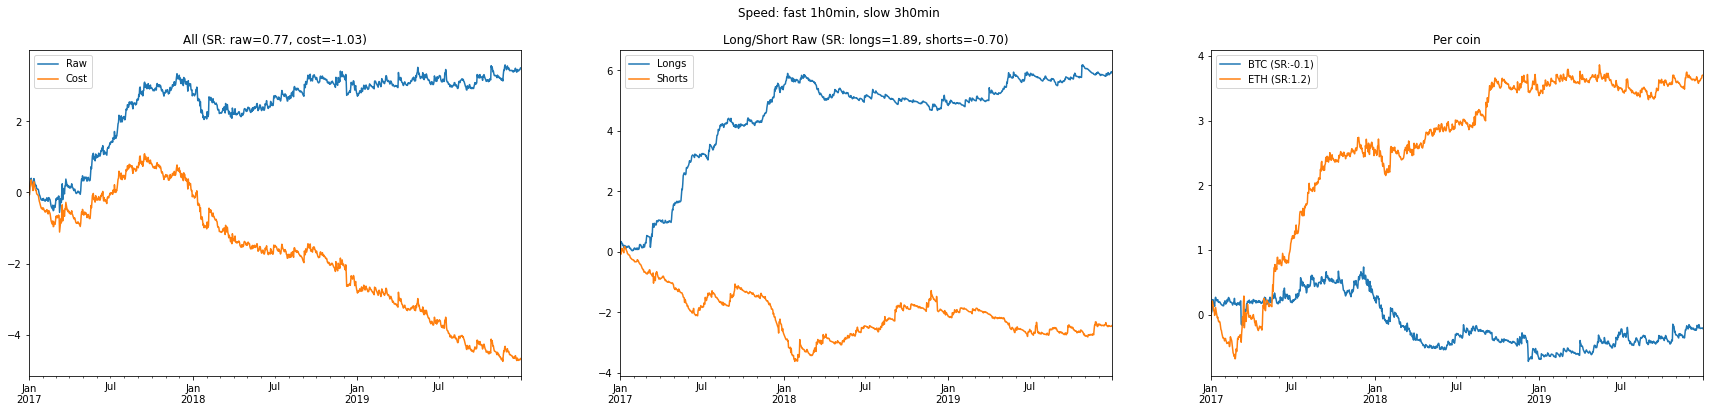

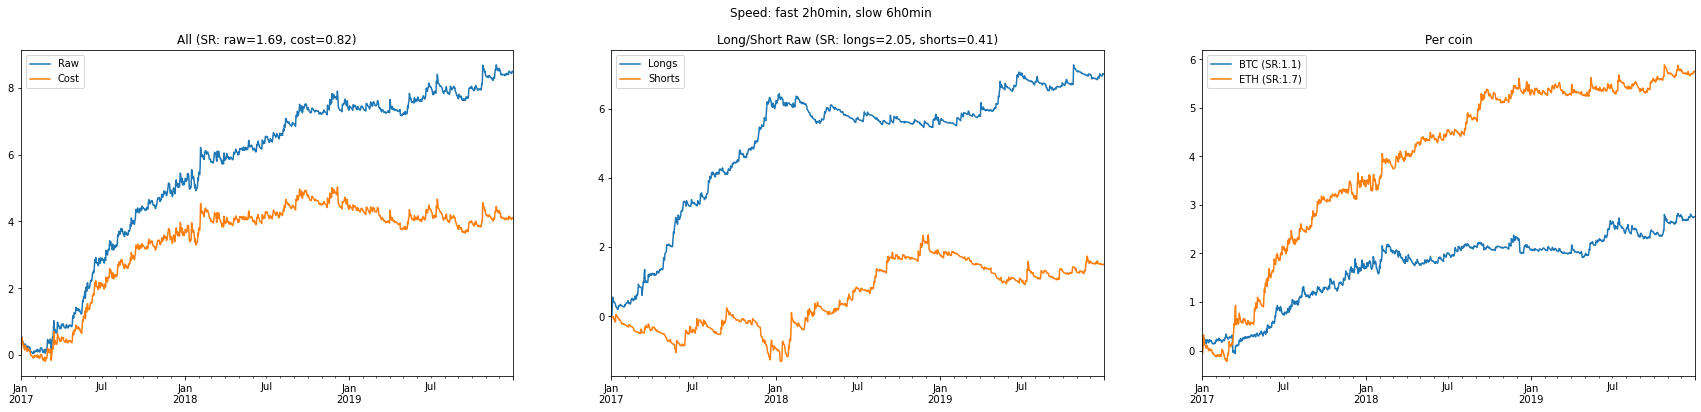

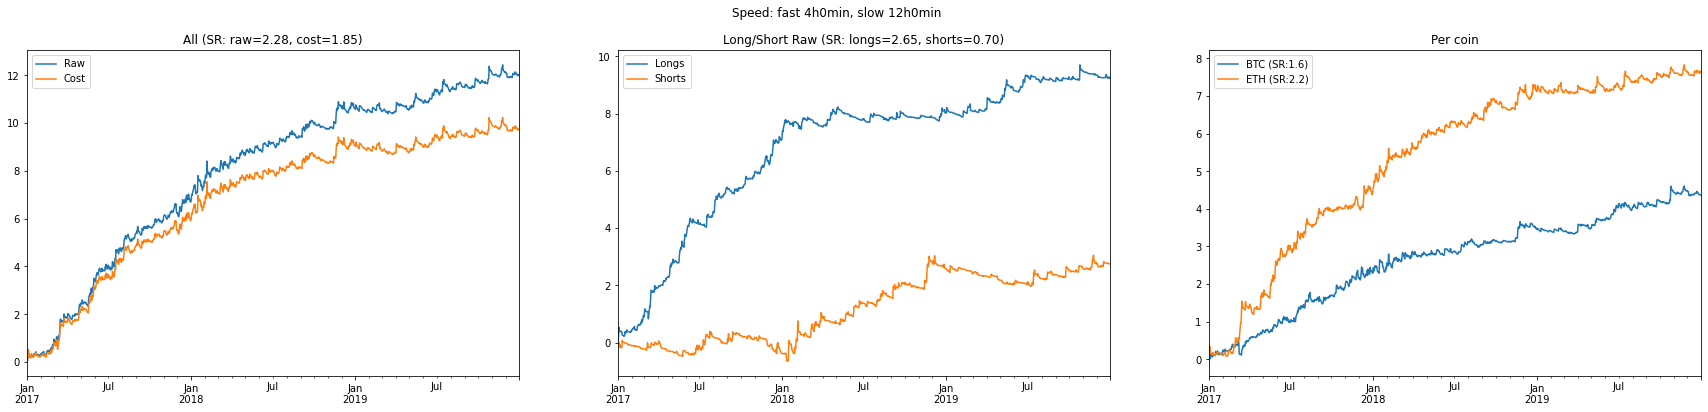

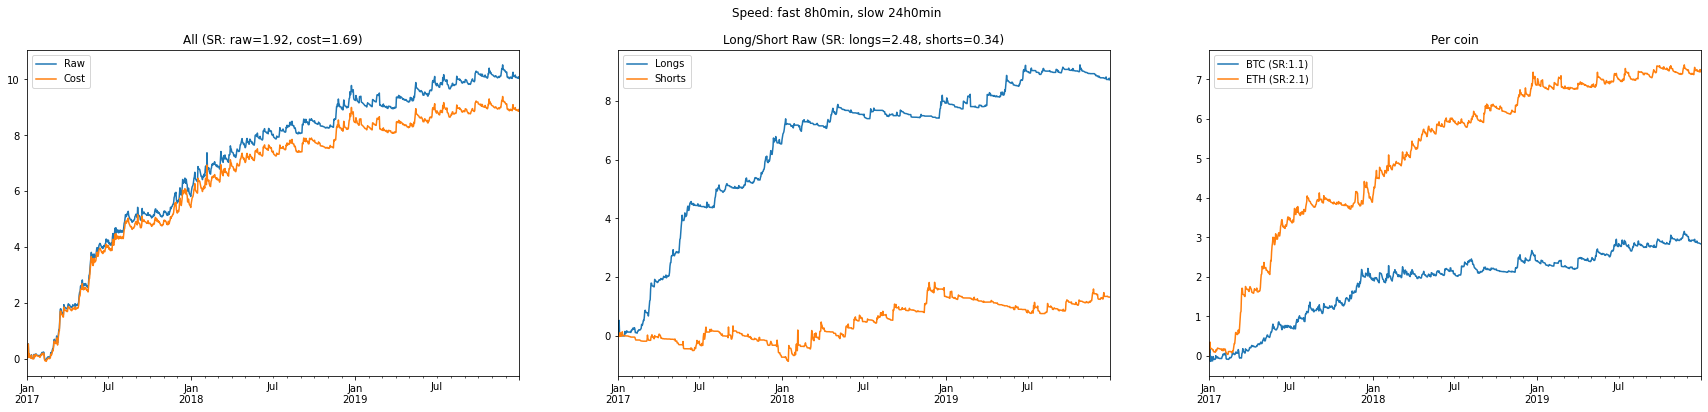

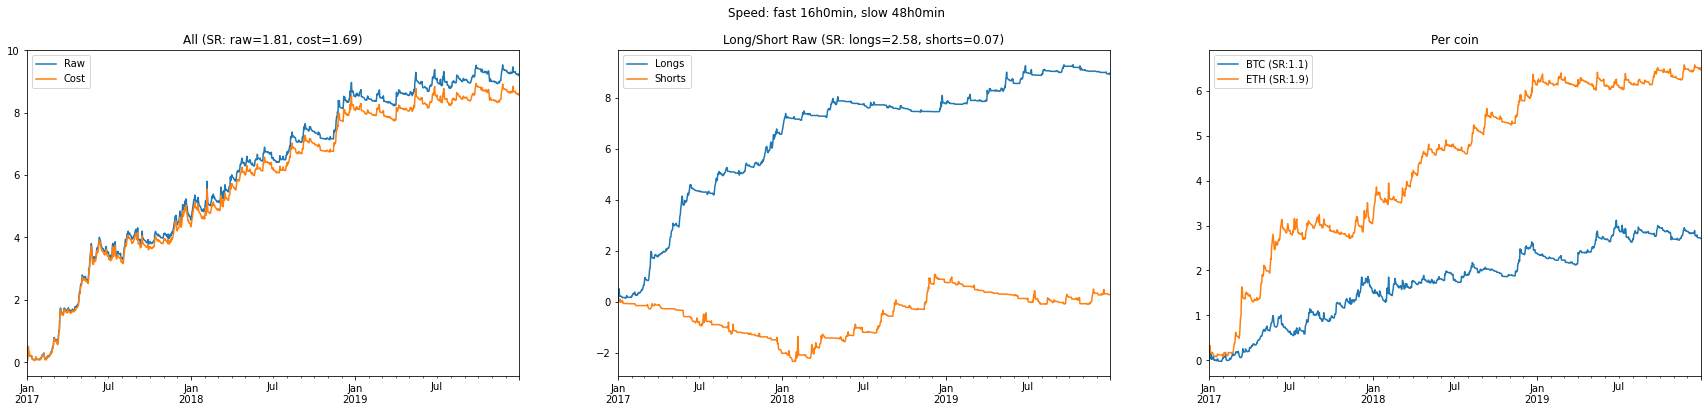

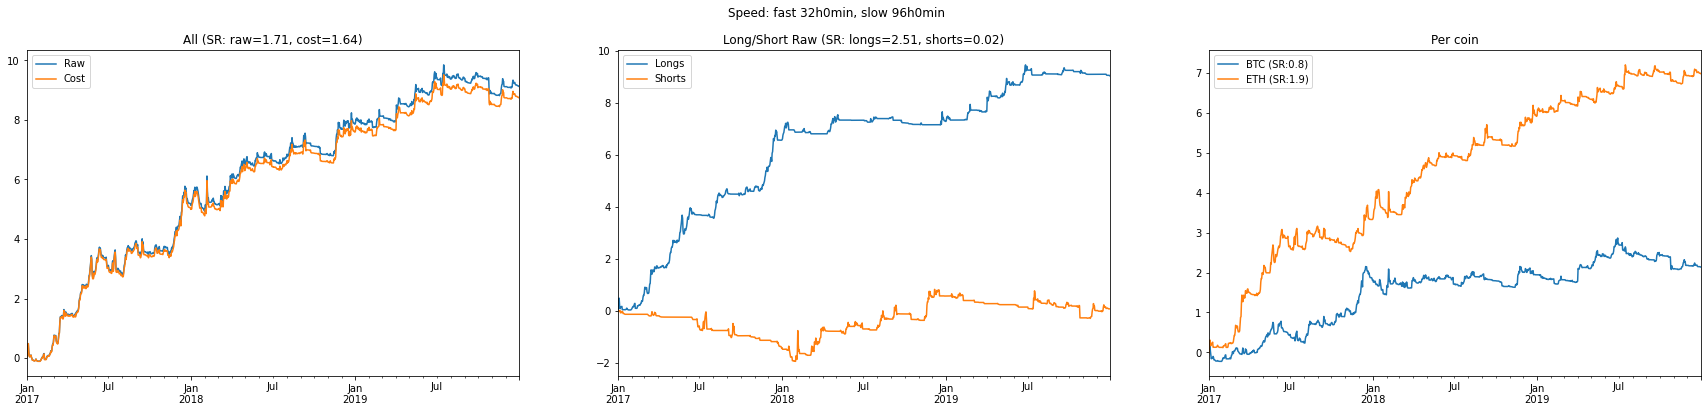

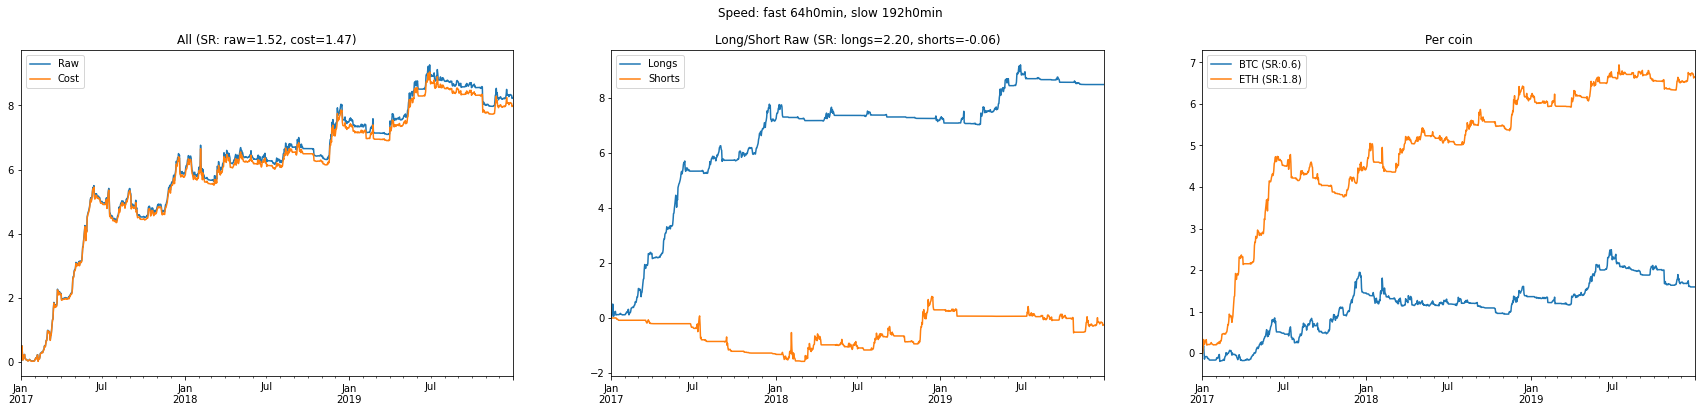

In [331]:
markets = ["BTC", "ETH"]
cost = 0.0003
plot_simulation(markets, cost, compute_signal)